In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import math

import keras
import keras.preprocessing.image
from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.preprocessing.csv_generator import CSVGenerator

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
keras.backend.tensorflow_backend.set_session(get_session())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys
print(sys.modules['keras_retinanet'].__file__)
print(sys.modules['keras_resnet'].__file__)
print(sys.modules['keras'].__file__)

/home/kai/.local/lib/python3.5/site-packages/keras_retinanet-0.0.1-py3.5.egg/keras_retinanet/__init__.py
/home/kai/.local/lib/python3.5/site-packages/keras_resnet/__init__.py
/usr/local/lib/python3.5/dist-packages/Keras-2.1.2-py3.5.egg/keras/__init__.py


In [135]:
# model = keras.models.load_model('../snapshots/resnet50_csv_06-10kbatch.h5', custom_objects=custom_objects)
# model = keras.models.load_model('../snapshots/circuit_resnet50_csv_35.h5', custom_objects=custom_objects)
model = keras.models.load_model('../snapshots/circuit_rf2/circuit_resnet50_csv_37.h5', custom_objects=custom_objects)
# model = keras.models.load_model('/media/kai/Data1/robotPrototype/calibration/modelSnapshots/circuit_resnet50_csv_02.h5', custom_objects=custom_objects)
# print(model.summary())

/usr/local/lib/python3.5/dist-packages/Keras-2.1.2-py3.5.egg/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
def add_noise(inData):
    result = np.random.normal(inData, scale=0.5).astype(np.uint8)
    print("adding noise ---- from {}:{} to {}:{}".format(inData.min(), inData.max(), result.min(), result.max()))
    return result

def set_to_zero(inData):
    result = np.zeros(inData.shape).astype(np.uint8)
    print("adding noise ---- from {}:{} to {}:{}".format(inData.min(), inData.max(), result.min(), result.max()))
    return result



In [129]:

def get2DPose(inFile):
    image = cv2.imread(inFile)
    print(image.shape)
    
    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = validation_generator.preprocess_image(image)
    print(image.shape)
    image, scale = validation_generator.resize_image(image)
    print(image.shape)
    print(scale)
    
    # process image
    start = time.time()
    detections = None
    _, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # compute predicted labels and scores
    predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
    scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]
    # correct for image scale
    detections[0, :, :4] /= scale
    
    b = None

    # visualize detections
    for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
        if score < 0.5:
            continue
            
        b = detections[0, idx, :4].astype(int)
        color = (0, 0, 255) if label == 0 else (255,0,0)
        cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), color, 3)
        caption = "{:.2f}".format(score)
        cv2.putText(draw, caption, (b[0], b[1] - 2), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0), 3)
        cv2.putText(draw, caption, (b[0], b[1] - 2), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 2)

        centerX = (b[2]+b[0])/2
        centerY = (b[3]+b[1])/2
        print(label, centerX, centerY, score)
        
    
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

    


# Tests

In [28]:
# create image data generator object
val_image_data_generator = keras.preprocessing.image.ImageDataGenerator()

validation_generator = CSVGenerator(
                '/media/kai/Data1/robotPrototype/data/MLRotation/annotationRF2.txt',
                '/media/kai/Data1/robotPrototype/data/MLRotation/classnameRF.txt',
                val_image_data_generator,
                batch_size=10
            )

2
(500, 500, 3)
(500, 500, 3)
(600, 600, 3)
1.2
processing time:  1.112673282623291
0 442.0 220.0 0.99710554
1 361.0 181.5 0.98312354
0 379.0 39.0 0.9379551
1 443.0 273.0 0.8342978
0 467.0 298.5 0.777317
1 423.0 285.5 0.6247981
0 401.5 245.0 0.51155615


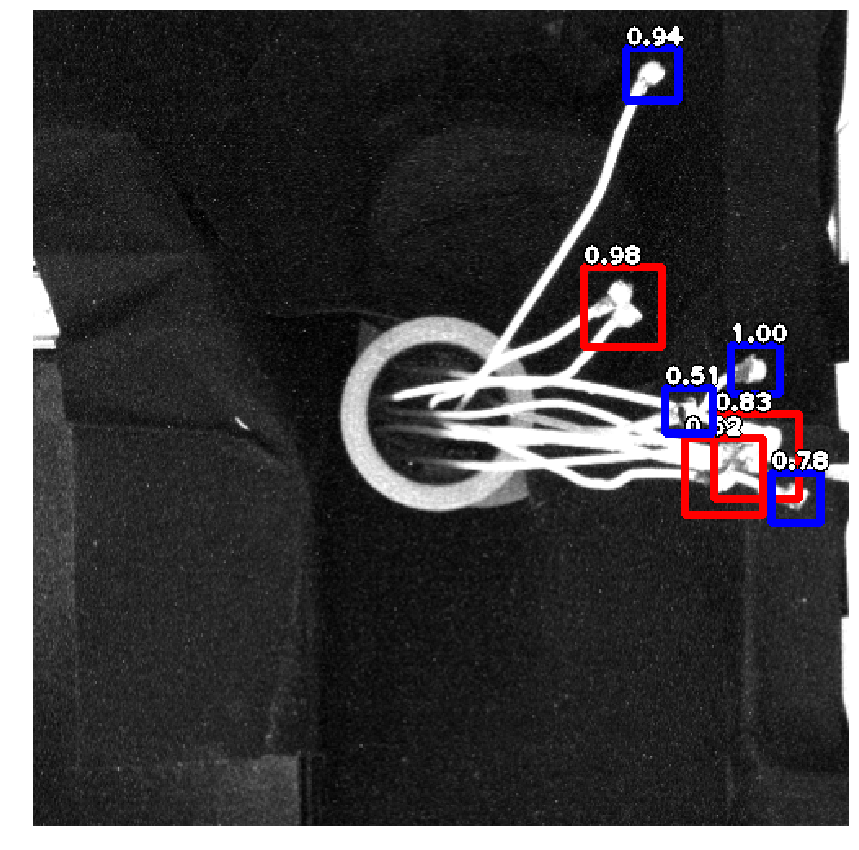

In [148]:
import random
index = random.randint(0,37)
testFile = "/media/kai/Data1/robotPrototype/data/MLRotation/rf2/validation/val{}.png".format(index)
print(index)
get2DPose(testFile)
